# Parser results -- Maltparser, default settings

This notebook will perform the same experiments as [the previous one](/notebooks/4.%20Analysis%20of%20parser%20results%20%28Mate%20tools%29.ipynb) for Mate tools, only instead using Maltparser run with default settings. We are also testing the entire UD 1.1 collection, instead of just looking at 1.0 as for Mate.

## Preprocessing

The conllu files had to be preprocessed to support the conllx format. This was done using the `tools/conllu2conllx.py` script. Thereafter the models were trained and tested with `tools/train_maltparser_default.py` and `tools/test_maltparser_default.py`.

#### Functional and content dependents
As specified in [A manual classification of dependency relations](/notebooks/3.%20A%20manual%20classification%20of%20dependency%20relations.ipynb)

- Functional dependents
- Content dependendents

#### Dependent classes as specified in the [UD documentation](http://universaldependencies.github.io/docs/u/dep/index.html)

- Classes expected to perform better than overall LAS for __synthetic__ languages:
  - __Core dependents of clausal predicates__: nsubj, csubj, nsubjpass, csubjpass, dobj, ccomp, xcomp, iobj
  - __Non-core dependents of clausal predicates__: nmod, advcl, advmod, neg
  - __Noun dependents, excluding _det_ and _neg___: nummod, acl, amod, appos, nmod
  - __Coordination, excluding _cc_ and _punct___: conj
  - 
- Classes expected to perform better than overall LAS for __isolated__ languages:
  - __Special clausal dependents__: vocative, aux, mark, discourse, auxpass, punct, expl, cop
  - __Case-marking, prepositions, possessive__: case


## Things to keep in mind when looking at the results

- Irish and Hungarian has fairly little data, and can't probably be trusted. 
- Czech has A LOT of data.

In [37]:
# Matplotlib
%matplotlib inline
import matplotlib
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
matplotlib.style.use('ggplot')

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys, os
sys.path.append("../tools/")
from collections import defaultdict

# Data management libraries
import pandas as pd
import seaborn as sns

# Treebank utils, found in "../tools"
import udeval, lang_utils, dependency_classes

is_labeled = True
is_fine_grained_deprels = True
file_format = "conllx"
test_type = "dev"

system_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/maltdefault_output_dev/"
gold_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-1/ud-treebanks-v1.1/"
file_prefix = "maltdefault"

system_files = lang_utils.get_system_output_paths(system_output_base, type_=test_type, format_=file_format)
gold_files = lang_utils.get_ud_paths(gold_output_base, type_=test_type, format_=file_format)

def labeled_attachment_scores():
    las = {}
    for lang, system_path in system_files.items():
        s_out = system_path
        g_out = gold_files[lang]
        score = udeval.attachment_score(s_out, g_out, labeled=is_labeled, fine_grained_deprels=is_fine_grained_deprels)
        las[lang] = score
    return pd.Series(las)

def precision_recall_filter_labels(labels):
    prec_recs = {"precision": [], "recall": []}
    index = []
    for lang, system_path in system_files.items():
        s_out = system_path
        g_out = gold_files[lang]
        precision, recall = udeval.labels_precision_recall(s_out, 
                                                           g_out, 
                                                           labels=labels,
                                                           fine_grained_deprels=is_labeled)
        index.append(lang)
        prec_recs["precision"].append(precision)
        prec_recs["recall"].append(recall)

    return pd.DataFrame(prec_recs, index=index).sort_values("precision")

In [38]:
las = labeled_attachment_scores()
las.to_csv('../data/' + file_prefix + '.las.csv')
las

Basque         0.642234
Bulgarian      0.825899
Croatian       0.757827
Czech          0.799150
Danish         0.763770
English        0.832512
Finnish        0.640432
Finnish-FTB    0.787755
French         0.816177
German         0.763147
Greek          0.744991
Hebrew         0.782535
Hungarian      0.662840
Indonesian     0.739454
Irish          0.705752
Italian        0.842128
Persian        0.812366
Spanish        0.810415
Swedish        0.739410
dtype: float64

In [6]:
all_labels_results = precision_recall_filter_labels(dependency_classes.all_labels)
all_labels_results

,precision,recall
Basque,0.642234,0.642234
Finnish,0.650237,0.650237
Hungarian,0.678937,0.678937
Irish,0.712465,0.712465
Swedish,0.734622,0.734622
Hebrew,0.734984,0.734984
Indonesian,0.739454,0.739454
Greek,0.747690,0.747690
Croatian,0.757827,0.757827
German,0.763147,0.763147


# Performance for dependency classes

We calculate the precision and recall only using the labels classified as content relations. We then subtract the LAS to present how large of an increase (or reduction) in results the label class gets.

### Content and function relations

#### Absolute performance

In [12]:
content_dependents_result = precision_recall_filter_labels(dependency_classes.content_dependents)
function_dependents_result = precision_recall_filter_labels(dependency_classes.function_dependents)
nonsemantic_dependents_result = precision_recall_filter_labels(dependency_classes.nonsemantic_dependents)
results_dict = {"Content": content_dependents_result, 
                "Function": function_dependents_result,
                "Nonsemantic": nonsemantic_dependents_result}

content_function_results = pd.concat(results_dict.values(), keys=results_dict.keys(), axis=1)

In [41]:
content_function_results.to_csv('../data/' + file_prefix + '.content_function_deprels.las.csv')
content_function_results

Content           Nonsemantic            Function          
            precision    recall   precision    recall precision    recall
Basque       0.592469  0.592469    0.638022  0.638022  0.804422  0.804422
Bulgarian    0.777082  0.777082    0.814063  0.814063  0.922995  0.922995
Croatian     0.737683  0.737683    0.716828  0.716828  0.829309  0.829309
Czech        0.792717  0.792717    0.706682  0.706682  0.886119  0.886119
Danish       0.780969  0.780969    0.627820  0.627820  0.876844  0.876844
English      0.805206  0.805206    0.762743  0.762743  0.921563  0.921563
Finnish      0.606343  0.606343    0.732759  0.732759  0.751449  0.751449
Finnish-FTB  0.752727  0.752727    0.919694  0.919694  0.812558  0.812558
French       0.774535  0.774535    0.629508  0.629508  0.921006  0.921006
German       0.702180  0.702180    0.688225  0.688225  0.886181  0.886181
Greek        0.688571  0.688571    0.549844  0.549844  0.892642  0.892642
Hebrew       0.689011  0.689011    0.627503  0.627503  0.890490  0.890490
Hungarian    0.554661  0.554661    0.622222  0.622222  0.870968  0.870968
Indonesian   0.730014  0.730014    0.636588  0.636588  0.853874  0.853874
Irish        0.605330  0.605330    0.763533  0.763533  0.880713  0.880713
Italian      0.772619  0.772619    0.741065  0.741065  0.958186  0.958186
Persian      0.740325  0.740325    0.776618  0.776618  0.884832  0.884832
Spanish      0.752576  0.752576    0.671259  0.671259  0.927029  0.927029
Swedish      0.704818  0.704818    0.622015  0.622015  0.814203  0.814203

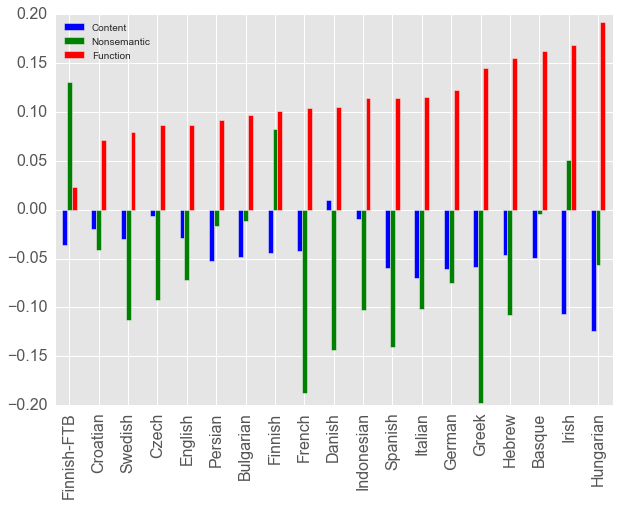

In [42]:
content_function_precisions = content_function_results.subtract(all_labels_results, level=1).xs('precision', level=1, axis=1)
content_function_precisions.sort_values('Function').plot(kind='bar', fontsize=16)

# What does this actually tell us?

Nothing, really, so far. Finnish might perform well on the few function relations it actually has. We need to look into function relations given how often they occur in the output. This is to be done in a later notebook.

In [39]:
core_dependent_result = precision_recall_filter_labels(dependency_classes.core_dependents)
noncore_dependents_result = precision_recall_filter_labels(dependency_classes.noncore_dependents)
noun_dependents_result = precision_recall_filter_labels(dependency_classes.noun_dependents)
coordination_dependents_result = precision_recall_filter_labels(dependency_classes.coordination_dependents)
special_clausal_dependents_result = precision_recall_filter_labels(dependency_classes.special_clausal_dependents)
other_functional_dependents_result = precision_recall_filter_labels(dependency_classes.other_functional_dependents)

ud_result_dict = {'Core': core_dependent_result,
                  'Noncore': noncore_dependents_result,
                  'Noun': noun_dependents_result,
                  'Coordination': coordination_dependents_result,
                  'Special clausal': special_clausal_dependents_result,
                  'Functionals': other_functional_dependents_result}

ud_class_result = pd.concat(ud_result_dict.values(), keys=ud_result_dict.keys(), axis=1)
ud_class_result

Special clausal           Functionals             Noncore  \
                  precision    recall   precision    recall precision   
Basque             0.714732  0.714732    0.751643  0.751643  0.597050   
Bulgarian          0.858592  0.858592    0.915672  0.915672  0.716344   
Croatian           0.757360  0.757360    0.843931  0.843931  0.766082   
Czech              0.755531  0.755531    0.899006  0.899006  0.769015   
Danish             0.740095  0.740095    0.891683  0.891683  0.726984   
English            0.830229  0.830229    0.921455  0.921455  0.764045   
Finnish            0.719459  0.719459    0.775596  0.775596  0.542984   
Finnish-FTB        0.900973  0.900973    0.820767  0.820767  0.745414   
French             0.699918  0.699918    0.931226  0.931226  0.772796   
German             0.749024  0.749024    0.907132  0.907132  0.698785   
Greek              0.690722  0.690722    0.892499  0.892499  0.716981   
Hebrew             0.741076  0.741076    0.894792  0.894792  0.656205   
Hungarian          0.647303  0.647303    0.888099  0.888099  0.574803   
Indonesian         0.672914  0.672914    0.851664  0.851664  0.705322   
Irish              0.768443  0.768443    0.894040  0.894040  0.522105   
Italian            0.800781  0.800781    0.964323  0.964323  0.781180   
Persian            0.769523  0.769523    0.918081  0.918081  0.719001   
Spanish            0.742450  0.742450    0.932916  0.932916  0.764857   
Swedish            0.716104  0.716104    0.813494  0.813494  0.662772   

                           Noun                Core           Coordination  \
               recall precision    recall precision    recall    precision   
Basque       0.597050  0.653728  0.653728  0.470290  0.470290     0.629740   
Bulgarian    0.716344  0.804262  0.804262  0.781603  0.781603     0.751184   
Croatian     0.766082  0.796778  0.796778  0.691438  0.691438     0.681609   
Czech        0.769015  0.844097  0.844097  0.784391  0.784391     0.692331   
Danish       0.726984  0.810669  0.810669  0.839225  0.839225     0.671795   
English      0.764045  0.855649  0.855649  0.849510  0.849510     0.743493   
Finnish      0.542984  0.601566  0.601566  0.591746  0.591746     0.705227   
Finnish-FTB  0.745414  0.778382  0.778382  0.751765  0.751765     0.855557   
French       0.772796  0.856153  0.856153  0.816429  0.816429     0.623987   
German       0.698785  0.829519  0.829519  0.627957  0.627957     0.698159   
Greek        0.716981  0.843284  0.843284  0.630675  0.630675     0.538606   
Hebrew       0.656205  0.746810  0.746810  0.645478  0.645478     0.662093   
Hungarian    0.574803  0.813036  0.813036  0.466837  0.466837     0.630137   
Indonesian   0.705322  0.690190  0.690190  0.756820  0.756820     0.613413   
Irish        0.522105  0.693168  0.693168  0.581858  0.581858     0.680431   
Italian      0.781180  0.886001  0.886001  0.724803  0.724803     0.708738   
Persian      0.719001  0.831392  0.831392  0.649613  0.649613     0.765206   
Spanish      0.764857  0.851110  0.851110  0.765664  0.765664     0.647169   
Swedish      0.662772  0.764601  0.764601  0.758448  0.758448     0.654328   

                       
               recall  
Basque       0.629740  
Bulgarian    0.751184  
Croatian     0.681609  
Czech        0.692331  
Danish       0.671795  
English      0.743493  
Finnish      0.705227  
Finnish-FTB  0.855557  
French       0.623987  
German       0.698159  
Greek        0.538606  
Hebrew       0.662093  
Hungarian    0.630137  
Indonesian   0.613413  
Irish        0.680431  
Italian      0.708738  
Persian      0.765206  
Spanish      0.647169  
Swedish      0.654328

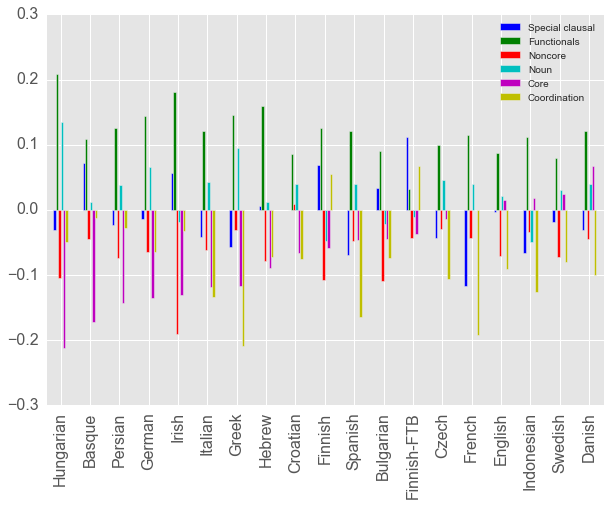

In [18]:
relative_ud_class_result = ud_class_result.subtract(all_labels_results, level=1).xs('precision', level=1, axis=1)
relative_ud_class_result.sort_values('Core').plot(kind='bar', fontsize=16)

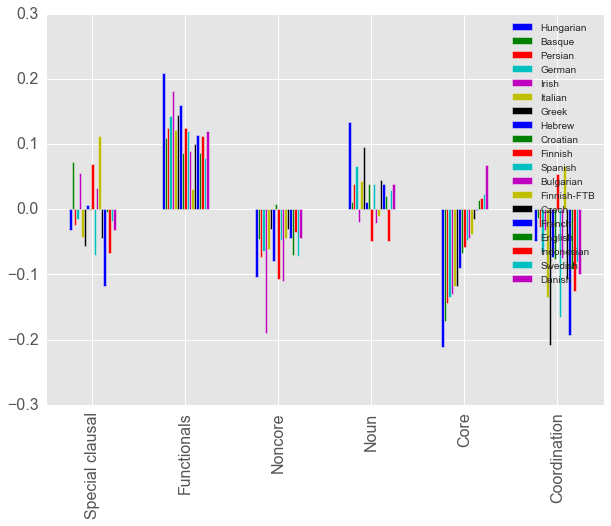

In [19]:
relative_ud_class_result.sort_values("Core").transpose().plot(kind='bar', fontsize=16)

In [33]:
add_order = [('core', dependency_classes.core_dependents),
             ('noncore', dependency_classes.noncore_dependents),
             ('coordination', dependency_classes.coordination_dependents),
             ('special_clausal', dependency_classes.special_clausal_dependents),
             ('noun', dependency_classes.noun_dependents),
             ('other', dependency_classes.other_dependents),
             ('compound_and_unanalyzed', dependency_classes.compound_and_unanalyzed_dependents),
             ('case_marking', dependency_classes.case_marking_dependents),
             ('loose_joining', dependency_classes.loose_joining_dependents)]


labels = []
cumul_results = []
cumul_name = ""
for class_name, label_class in add_order:
    labels += label_class
    labels_result = precision_recall_filter_labels(labels)
    cumul_name = "+" + class_name
    cumul_results.append((cumul_name, labels_result))

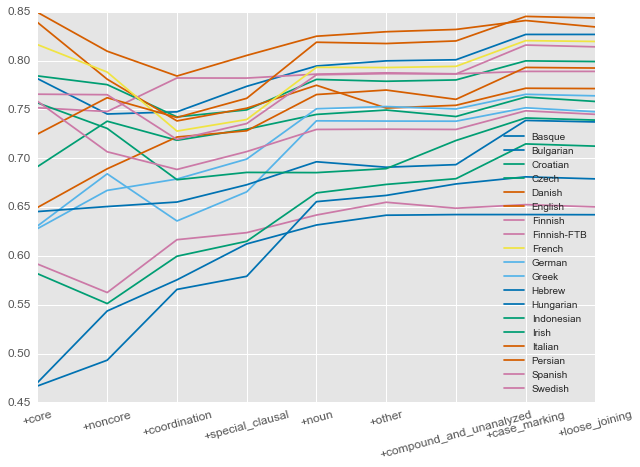

In [34]:
cmap1 = mpl.colors.ListedColormap(sns.color_palette("colorblind", 10))
pd.DataFrame([x[1]['precision'] for x in cumul_results], index=[x[0] for x in cumul_results]).plot(rot=15, fontsize=12, cmap=cmap1)

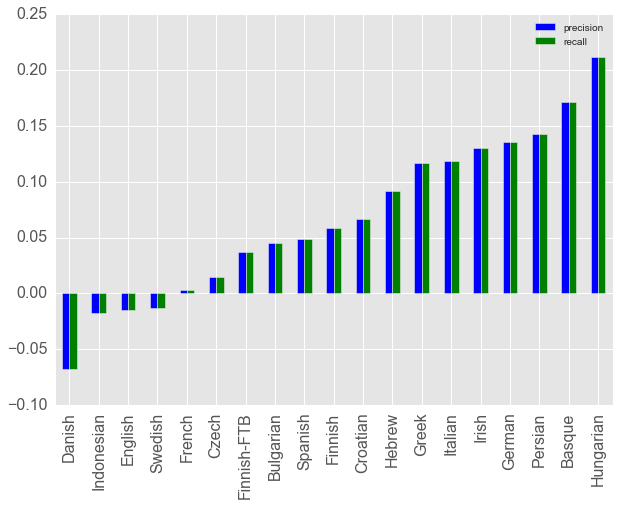

In [35]:
(cumul_results[-1][1] - cumul_results[0][1]).sort_values("precision").plot(kind='bar', fontsize=16)